In [425]:
import dac
from dac.model.dac import EncoderBlock, DecoderBlock, ResidualUnit
from dac.nn.layers import Snake1d
from audiotools import AudioSignal
import torch
from torch import nn
import copy

In [ ]:
model_path = dac.utils.download(model_type="44khz")
model = dac.DAC.load(model_path)

In [427]:
model

DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
              (2): Snake1d()
              

In [428]:
conv_layers = []

for idx, layer in enumerate(model.encoder.block):
    print(idx, layer)
    if isinstance(layer, nn.Conv1d):
        print("nn.Conv1d here")
        conv_layers.append(layer)
    elif isinstance(layer, EncoderBlock):
        encoder_block_layers = layer.block
        print("encoder block here")
        for encoder_block_layer in encoder_block_layers:
            if isinstance(encoder_block_layer, nn.Conv1d):
                print("nn.Conv1d here")
                conv_layers.append(encoder_block_layer)
            elif isinstance(encoder_block_layer, ResidualUnit):
                residual_unit_layers = encoder_block_layer.block
                print("residual unit here")
                for residual_unit_layer in residual_unit_layers:
                    if isinstance(residual_unit_layer, nn.Conv1d):
                        print("nn.Conv1d here")
                        conv_layers.append(residual_unit_layer)
            

0 Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
nn.Conv1d here
1 EncoderBlock(
  (block): Sequential(
    (0): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
        (2): Snake1d()
        (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      )
    )
    (1): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
        (2): Snake1d()
        (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      )
    )
    (2): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
        (2): Snake1d()
        (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      )
    )
    (3): Snake1d()
    (4): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  )
)
encoder block here
residual unit 

In [429]:
conv_layers = []

for idx, layer in enumerate(model.decoder.model):
    print(idx, layer)
    if isinstance(layer, nn.Conv1d):
        print("nn.Conv1d here")
        conv_layers.append(layer)
    elif isinstance(layer, DecoderBlock):
        decoder_block_layers = layer.block
        print("encoder block here")
        for decoder_block_layer in decoder_block_layers:
            if isinstance(decoder_block_layer, nn.Conv1d):
                print("nn.Conv1d here")
                conv_layers.append(decoder_block_layer)
            elif isinstance(decoder_block_layer, ResidualUnit):
                residual_unit_layers = decoder_block_layer.block
                print("residual unit here")
                for residual_unit_layer in residual_unit_layers:
                    if isinstance(residual_unit_layer, nn.Conv1d):
                        print("nn.Conv1d here")
                        conv_layers.append(residual_unit_layer)

conv_layers

0 Conv1d(1024, 1536, kernel_size=(7,), stride=(1,), padding=(3,))
nn.Conv1d here
1 DecoderBlock(
  (block): Sequential(
    (0): Snake1d()
    (1): ConvTranspose1d(1536, 768, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(3,))
        (2): Snake1d()
        (3): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
        (2): Snake1d()
        (3): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
    (4): ResidualUnit(
      (block): Sequential(
        (0): Snake1d()
        (1): Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
        (2): Snake1d()
        (3): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
      )
    )
  )
)
enco

[Conv1d(1024, 1536, kernel_size=(7,), stride=(1,), padding=(3,)),
 Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(3,)),
 Conv1d(768, 768, kernel_size=(1,), stride=(1,)),
 Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)),
 Conv1d(768, 768, kernel_size=(1,), stride=(1,)),
 Conv1d(768, 768, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)),
 Conv1d(768, 768, kernel_size=(1,), stride=(1,)),
 Conv1d(384, 384, kernel_size=(7,), stride=(1,), padding=(3,)),
 Conv1d(384, 384, kernel_size=(1,), stride=(1,)),
 Conv1d(384, 384, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)),
 Conv1d(384, 384, kernel_size=(1,), stride=(1,)),
 Conv1d(384, 384, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)),
 Conv1d(384, 384, kernel_size=(1,), stride=(1,)),
 Conv1d(192, 192, kernel_size=(7,), stride=(1,), padding=(3,)),
 Conv1d(192, 192, kernel_size=(1,), stride=(1,)),
 Conv1d(192, 192, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3

In [430]:
def find_conv_layers(layers, conv_layers):
    for layer in layers:
        if isinstance(layer, (nn.Conv1d, nn.ConvTranspose1d)):
            conv_layers.append(layer)
        elif hasattr(layer, 'block'):
            find_conv_layers(layer.block, conv_layers)

encoder_conv_layers = []
decoder_conv_layers = []

find_conv_layers(model.encoder.block, encoder_conv_layers)
find_conv_layers(model.decoder.model, decoder_conv_layers)

encoder_conv_layers, decoder_conv_layers

([Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,)),
  Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,)),
  Conv1d(64, 64, kernel_size=(1,), stride=(1,)),
  Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)),
  Conv1d(64, 64, kernel_size=(1,), stride=(1,)),
  Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)),
  Conv1d(64, 64, kernel_size=(1,), stride=(1,)),
  Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,)),
  Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,)),
  Conv1d(128, 128, kernel_size=(1,), stride=(1,)),
  Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)),
  Conv1d(128, 128, kernel_size=(1,), stride=(1,)),
  Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)),
  Conv1d(128, 128, kernel_size=(1,), stride=(1,)),
  Conv1d(128, 256, kernel_size=(8,), stride=(4,), padding=(2,)),
  Conv1d(256, 256, kernel_size=(7,), stride=(1,), padding=(3,))

In [431]:
# function to sort the channels from important to non-important
def get_input_channel_importance_conv1d(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

# function to sort the channels from important to non-important
def get_input_channel_importance_convtranspose1d(weight):
    in_channels = weight.shape[0]
    importances = []
    # compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[i_c, :]
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    # model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv from the model
    all_convs = []
    find_conv_layers(model.encoder.block, all_convs)
    find_conv_layers(model.decoder.model, all_convs)
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        if (isinstance(next_conv, nn.ConvTranspose1d)):
            importance = get_input_channel_importance_convtranspose1d(next_conv.weight)
        else:
            importance = get_input_channel_importance_conv1d(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)
        
        # apply to the next conv input
        if (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))
        elif (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.ConvTranspose1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 0, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 0, sort_idx))
        elif (isinstance(prev_conv, nn.ConvTranspose1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.copy_(torch.index_select(prev_conv.weight.detach(), 1, sort_idx))
            next_conv.weight.copy_(torch.index_select(next_conv.weight.detach(), 1, sort_idx))

    return model

In [432]:
from typing import Union, List

def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    return round((1 - prune_ratio) * channels)

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    # fetch all the conv from the model
    all_convs = []
    find_conv_layers(model.encoder.block, all_convs)
    find_conv_layers(model.decoder.model, all_convs)
    n_conv = len(all_convs)
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    # model = copy.deepcopy(model)  # prevent overwrite
    # apply pruning. we naively keep the first k channels
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        if (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
            next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep, :])
        elif (isinstance(prev_conv, nn.Conv1d) and isinstance(next_conv, nn.ConvTranspose1d)):
            prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
            next_conv.weight.set_(next_conv.weight.detach()[:n_keep])
        elif (isinstance(prev_conv, nn.ConvTranspose1d) and isinstance(next_conv, nn.Conv1d)):
            prev_conv.weight.set_(prev_conv.weight.detach()[:, :n_keep, :])
            next_conv.weight.set_(next_conv.weight.detach()[:, :n_keep, :])

    return model

In [433]:
print("Before pruning")
all_convs = []
find_conv_layers(model.encoder.block, all_convs)
find_conv_layers(model.decoder.model, all_convs)
for conv in all_convs:
    print(conv, conv.weight.shape)


Before pruning
Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,)) torch.Size([64, 1, 7])
Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,)) torch.Size([64, 64, 7])
Conv1d(64, 64, kernel_size=(1,), stride=(1,)) torch.Size([64, 64, 1])
Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)) torch.Size([64, 64, 7])
Conv1d(64, 64, kernel_size=(1,), stride=(1,)) torch.Size([64, 64, 1])
Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)) torch.Size([64, 64, 7])
Conv1d(64, 64, kernel_size=(1,), stride=(1,)) torch.Size([64, 64, 1])
Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,)) torch.Size([128, 64, 4])
Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,)) torch.Size([128, 128, 7])
Conv1d(128, 128, kernel_size=(1,), stride=(1,)) torch.Size([128, 128, 1])
Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)) torch.Size([128, 128, 7])
Conv1d(128, 128, kernel_size=(1,), stride=(1,)) torch.Size(

In [434]:
channel_pruning_ratio = 0.3
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)

In [435]:
print("After pruning")
all_convs = []
find_conv_layers(model.encoder.block, all_convs)
find_conv_layers(model.decoder.model, all_convs)
for conv in all_convs:
    print(conv, conv.weight.shape)

After pruning
Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,)) torch.Size([45, 1, 7])
Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,)) torch.Size([45, 45, 7])
Conv1d(64, 64, kernel_size=(1,), stride=(1,)) torch.Size([45, 45, 1])
Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)) torch.Size([45, 45, 7])
Conv1d(64, 64, kernel_size=(1,), stride=(1,)) torch.Size([45, 45, 1])
Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,)) torch.Size([45, 45, 7])
Conv1d(64, 64, kernel_size=(1,), stride=(1,)) torch.Size([45, 45, 1])
Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,)) torch.Size([90, 45, 4])
Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,)) torch.Size([90, 90, 7])
Conv1d(128, 128, kernel_size=(1,), stride=(1,)) torch.Size([90, 90, 1])
Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,)) torch.Size([90, 90, 7])
Conv1d(128, 128, kernel_size=(1,), stride=(1,)) torch.Size([90, 90,

Compress and Decompress + Evaluate

In [436]:
from dac.utils import load_model
from dac import DACFile
from train import losses
from dataclasses import dataclass

ref_generator = load_model(
    model_type="44khz",
    model_bitrate="8kbps",
    tag="latest",
    load_path=model_path,
)

audio_file_path = "../samples/UrbanSound8K 7383-3-0-0.wav"

signal = AudioSignal(audio_file_path)

artifact = ref_generator.compress(signal, win_duration=5.0, verbose=False)

recons = ref_generator.decompress(artifact, verbose=False)

waveform_loss = losses.L1Loss()
stft_loss = losses.MultiScaleSTFTLoss()
mel_loss = losses.MelSpectrogramLoss()

x = signal.clone().resample(44100)
y = recons.clone().resample(44100)
mel_loss(x, y), stft_loss(x, y), waveform_loss(x, y)

(tensor(1.0102), tensor(2.0919), tensor(0.0179))

In [437]:
artifact, recons

(DACFile(codes=tensor([[[568, 698, 481,  ..., 205, 283, 283],
          [778, 245, 331,  ..., 678, 245, 538],
          [708, 737, 182,  ...,  20, 624, 379],
          ...,
          [500, 263, 801,  ..., 120, 506, 687],
          [860, 788, 943,  ..., 675, 997, 802],
          [628, 367, 112,  ..., 366, 349, 597]],
 
         [[568, 698, 618,  ..., 315, 283, 315],
          [778, 245, 914,  ..., 217,   7, 898],
          [566,  10, 879,  ..., 333, 624, 702],
          ...,
          [545,  63, 847,  ..., 972, 147, 668],
          [614, 579, 746,  ..., 613, 153,  98],
          [628, 827, 799,  ..., 929, 663, 870]]]), chunk_length=345, original_length=176400, input_db=tensor([-18.7919]), channels=2, sample_rate=44100, padding=True, dac_version='1.0.0'),
 <audiotools.core.audio_signal.AudioSignal at 0x204c9e64290>)

In [438]:
x,y

(<audiotools.core.audio_signal.AudioSignal at 0x204c76c3bd0>,
 <audiotools.core.audio_signal.AudioSignal at 0x204c79aead0>)

In [439]:
channel_pruning_ratio = 0.3
sorted_model = apply_channel_sorting(ref_generator)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)

artifact = pruned_model.compress(signal, win_duration=5.0, verbose=False)

recons = pruned_model.decompress(artifact, verbose=False)

waveform_loss = losses.L1Loss()
stft_loss = losses.MultiScaleSTFTLoss()
mel_loss = losses.MelSpectrogramLoss()

x = signal.clone().resample(44100)
y = recons.clone().resample(44100)
mel_loss(x, y), stft_loss(x, y), waveform_loss(x, y)

(tensor(1.0102), tensor(2.0919), tensor(0.0179))

In [440]:
artifact, recons

(DACFile(codes=tensor([[[568, 698, 481,  ..., 205, 283, 283],
          [778, 245, 331,  ..., 678, 245, 538],
          [708, 737, 182,  ...,  20, 624, 379],
          ...,
          [500, 263, 801,  ..., 120, 506, 687],
          [860, 788, 943,  ..., 675, 997, 802],
          [628, 367, 112,  ..., 366, 349, 597]],
 
         [[568, 698, 618,  ..., 315, 283, 315],
          [778, 245, 914,  ..., 217,   7, 898],
          [566,  10, 879,  ..., 333, 624, 702],
          ...,
          [545,  63, 847,  ..., 972, 147, 668],
          [614, 579, 746,  ..., 613, 153,  98],
          [628, 827, 799,  ..., 929, 663, 870]]]), chunk_length=345, original_length=176400, input_db=tensor([-18.7919]), channels=2, sample_rate=44100, padding=True, dac_version='1.0.0'),
 <audiotools.core.audio_signal.AudioSignal at 0x204ca04add0>)

In [441]:
x, y

(<audiotools.core.audio_signal.AudioSignal at 0x204c774c0d0>,
 <audiotools.core.audio_signal.AudioSignal at 0x204ca04a350>)

In [442]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def uniform_sparsity_testing(model_path, audio_file_path, channel_pruning_ratios):
    mel_losses = []
    stft_losses = []
    waveform_losses = []

    waveform_loss = losses.L1Loss()
    stft_loss = losses.MultiScaleSTFTLoss()
    mel_loss = losses.MelSpectrogramLoss()

    signal = AudioSignal(audio_file_path)

    for channel_pruning_ratio in tqdm(channel_pruning_ratios):
        model = dac.DAC.load(model_path)

        sorted_model = apply_channel_sorting(model)
        pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
        # all_convs = []
        # find_conv_layers(pruned_model.encoder.block, all_convs)
        # find_conv_layers(pruned_model.decoder.model, all_convs)
        # for conv in all_convs:
        #     print(conv, conv.weight.shape)
        # print(all_convs[0].weight)

        artifact = pruned_model.compress(signal.clone(), win_duration=5.0, verbose=False)
        recons = pruned_model.decompress(artifact, verbose=False)

        x = signal.clone().resample(44100)
        y = recons.clone().resample(44100)

        mel_losses.append(mel_loss(x, y))
        stft_losses.append(stft_loss(x, y))
        waveform_losses.append(waveform_loss(x, y))

    plt.figure()
    plt.plot(channel_pruning_ratios, mel_losses, label='Mel Loss')
    plt.plot(channel_pruning_ratios, stft_losses, label='STFT Loss')
    plt.plot(channel_pruning_ratios, waveform_losses, label='Waveform Loss')

    plt.xlabel('Channel Pruning Ratio')
    plt.ylabel('Loss')
    
    plt.title('Losses for Different Channel Pruning Ratios')

    plt.legend()

    plt.show()


100%|██████████| 8/8 [01:10<00:00,  8.84s/it]


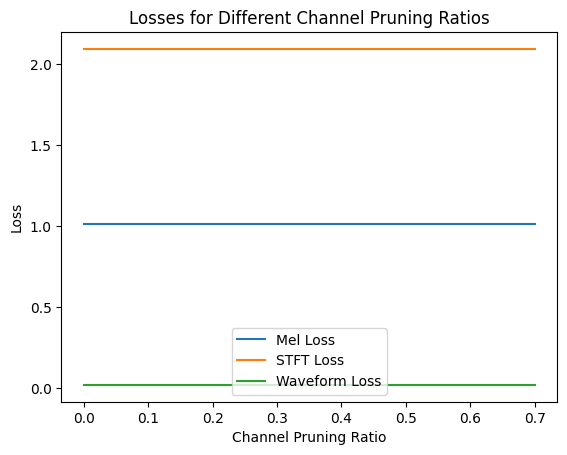

In [443]:
audio_file_path = "../samples/UrbanSound8K 7383-3-0-0.wav"
channel_pruning_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
uniform_sparsity_testing(model_path, audio_file_path, channel_pruning_ratios)